# Internal-External Development and Cross-Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

Loading required package: rms
Loading required package: Hmisc

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
library(rsample) # for group_vfold_cv()
library(furrr) # for future_map()


Loading required package: future

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ tune         1.2.0 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ yardstick::spec()    masks readr::spec()
✖ Hmisc::src()         masks dplyr::src()
✖ recipes::step()      masks stats::step()
✖ Hmisc::summarize()   masks dplyr::summarize()
✖ parsnip::translate() masks Hmisc::translate()
• Use suppressPackageStartupMessages() to eliminate package startup messages

In [ ]:
# cross_plots_HPM


[[1]]

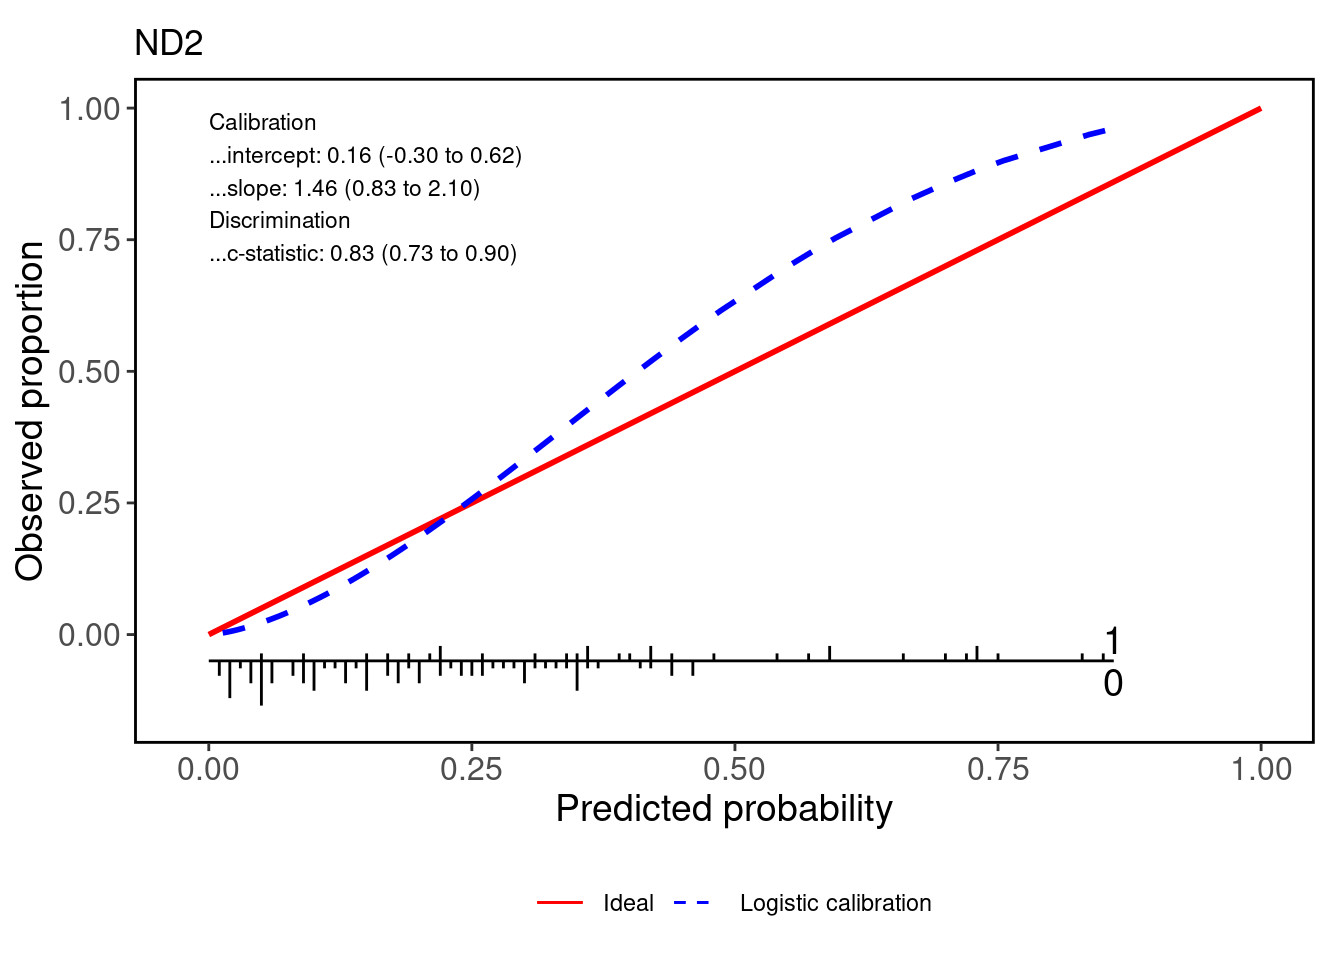


[[2]]

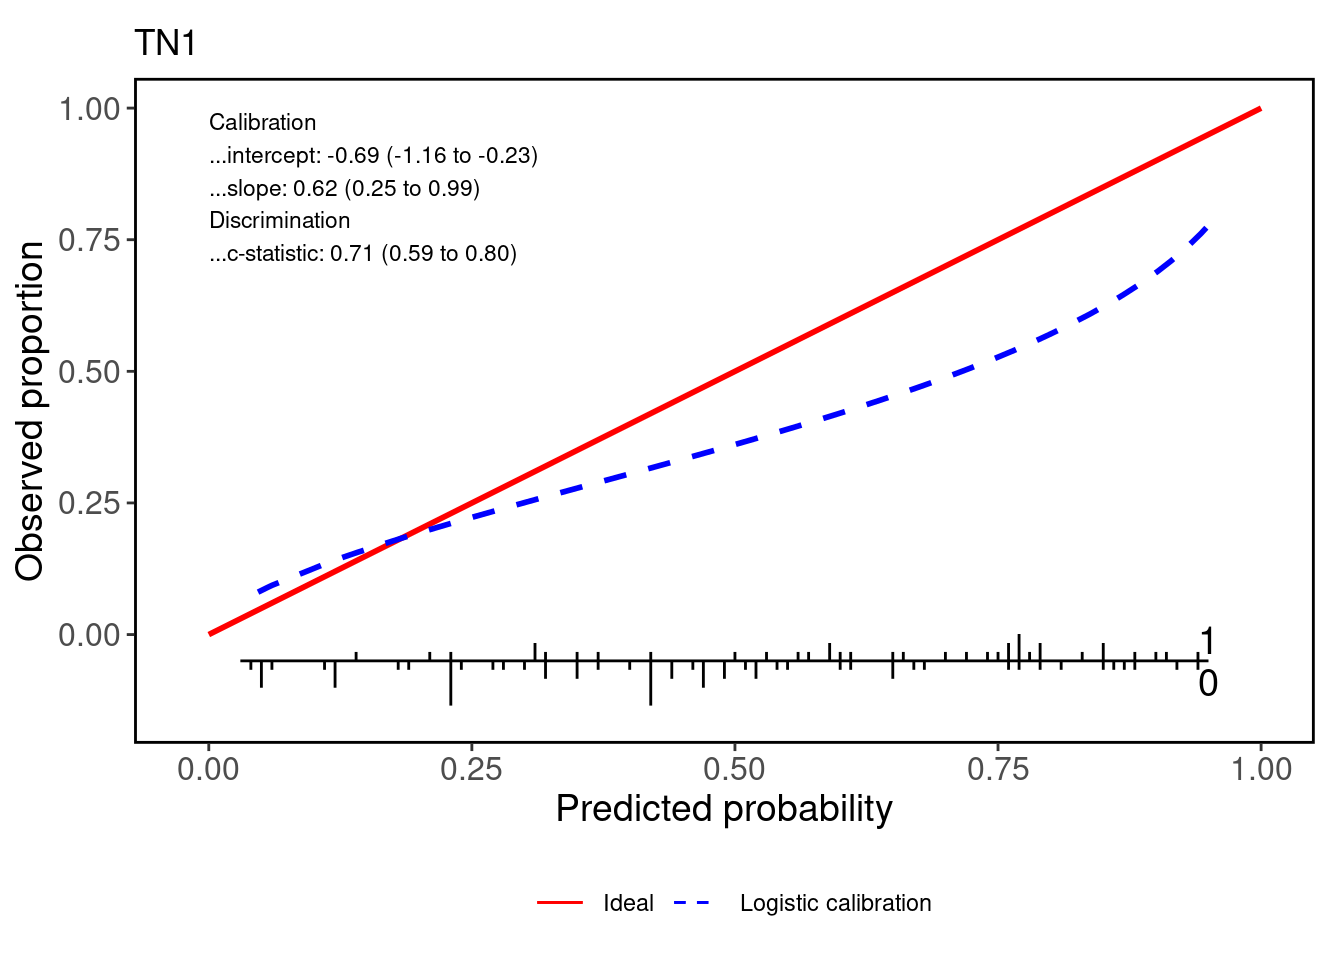


[[3]]

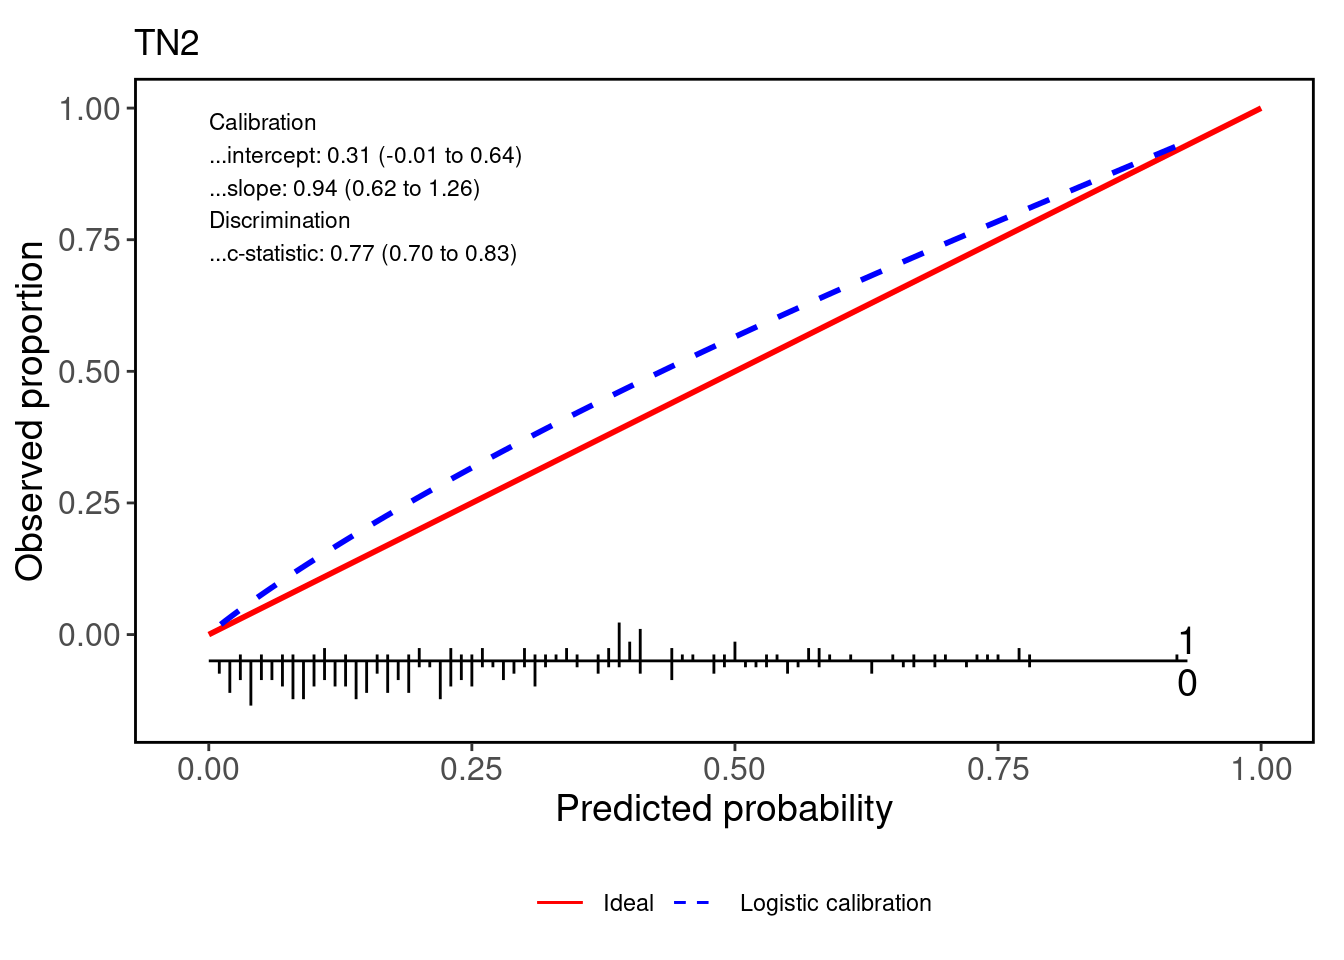


[[4]]

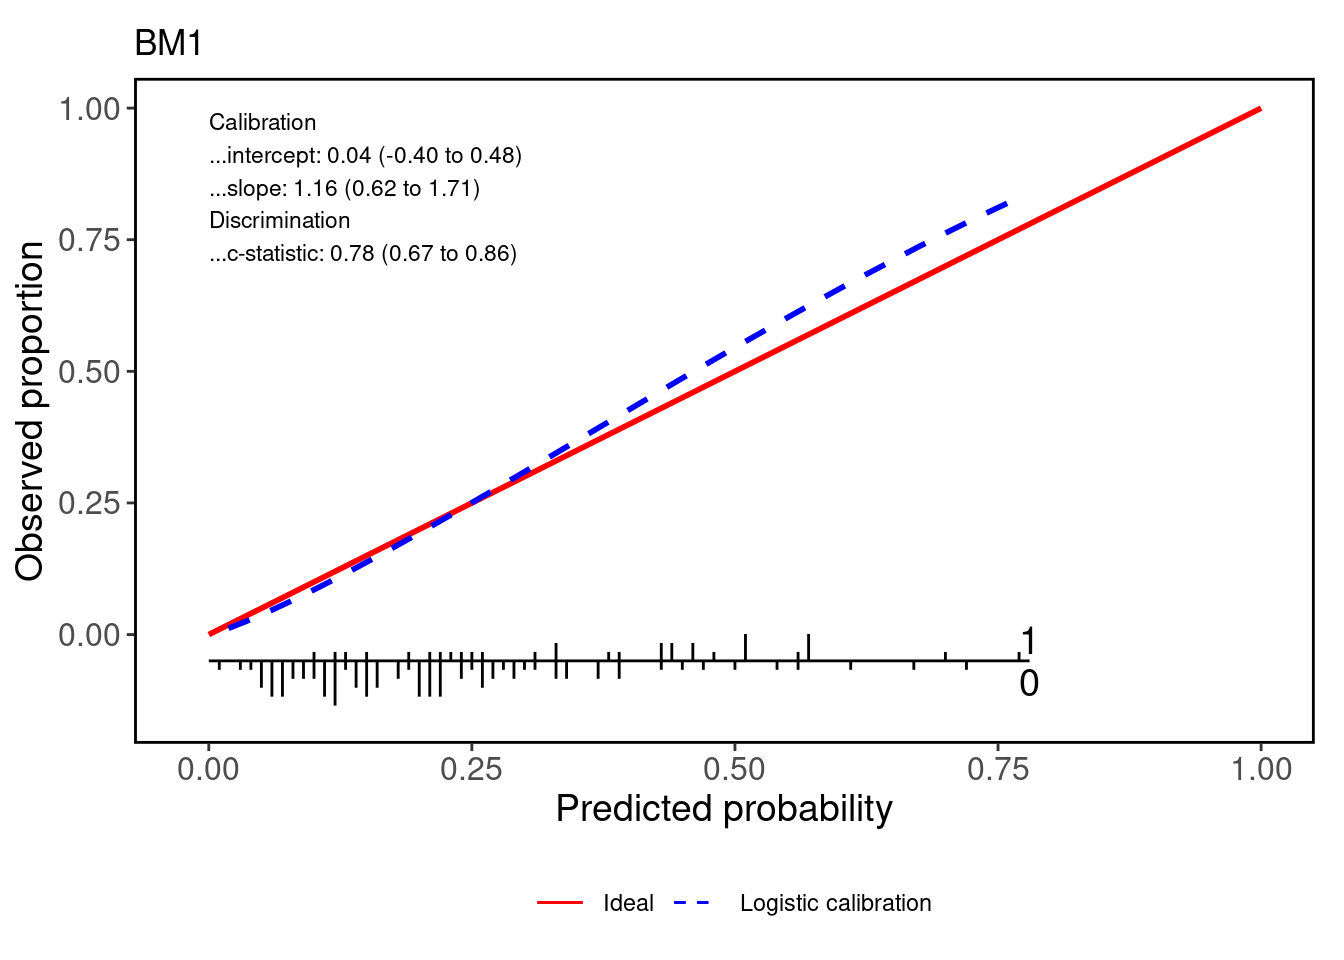


[[5]]

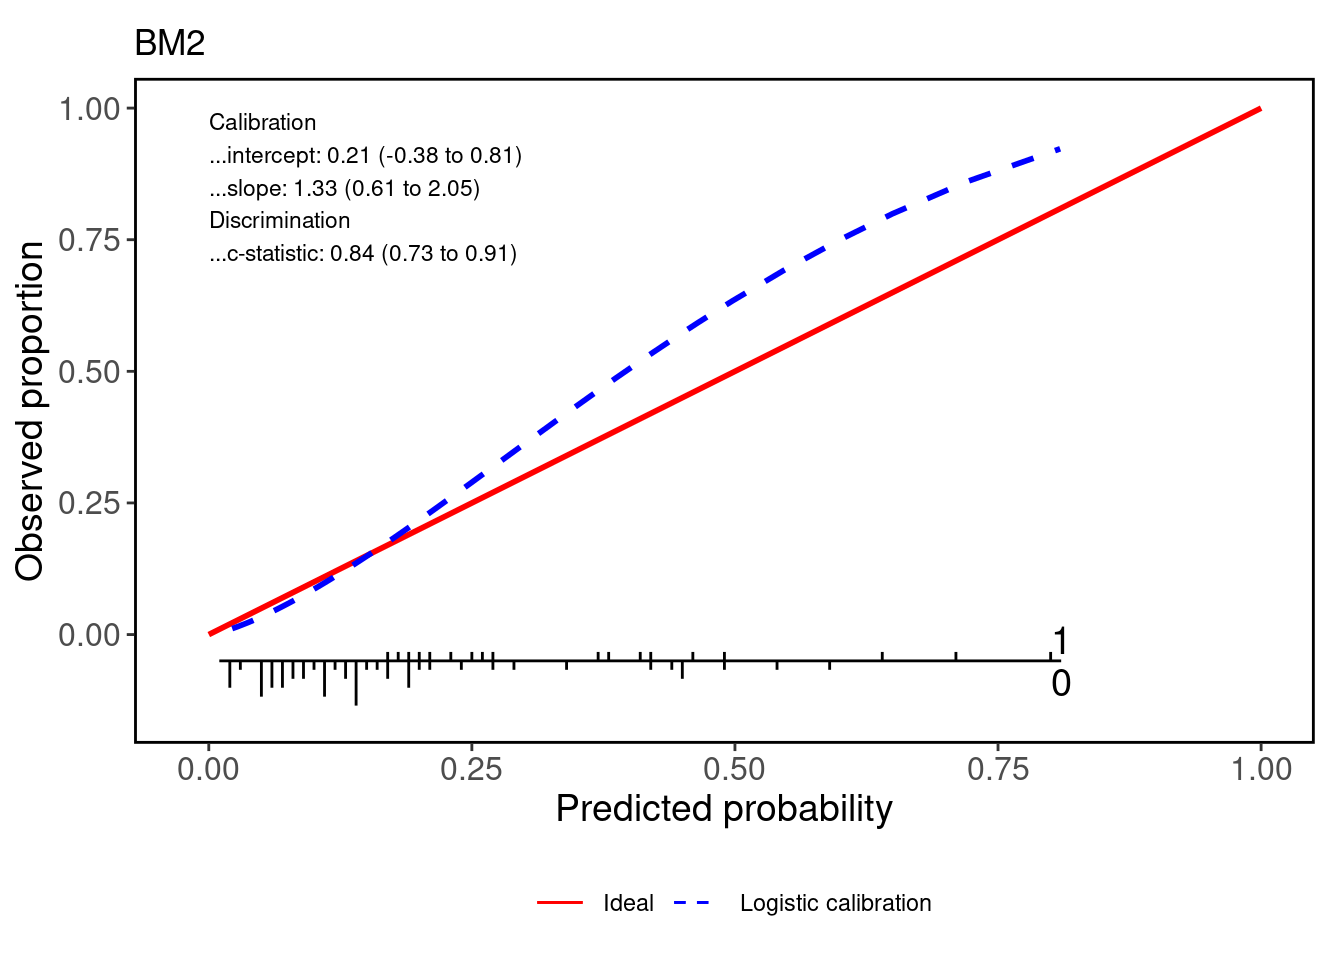


[[6]]

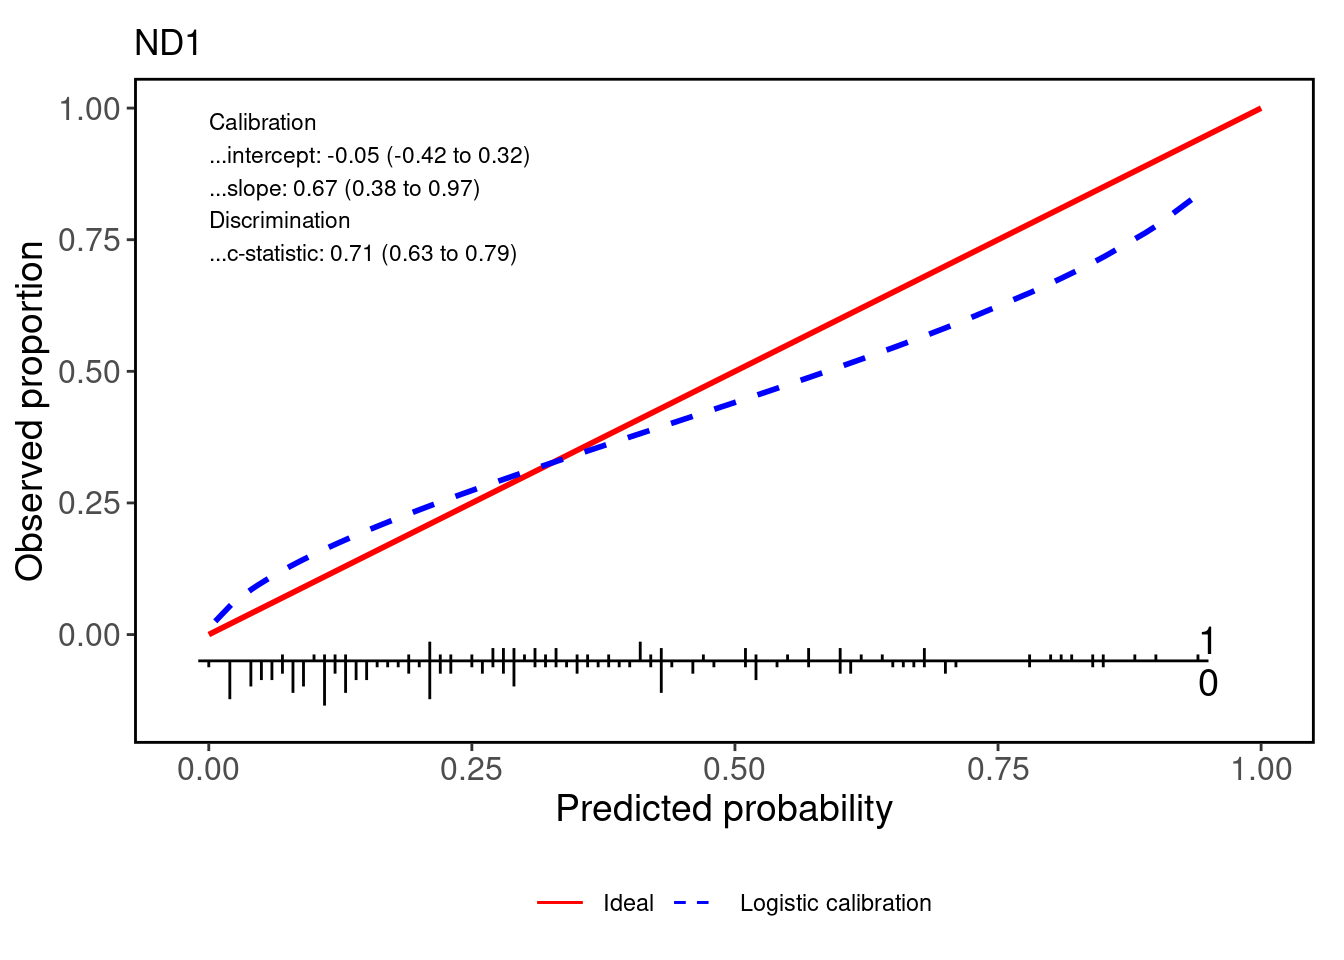

In [ ]:
cross_plots_BPM


In [ ]:
library(meta)


Loading required package: metadat

Loading 'meta' package (version 7.0-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs

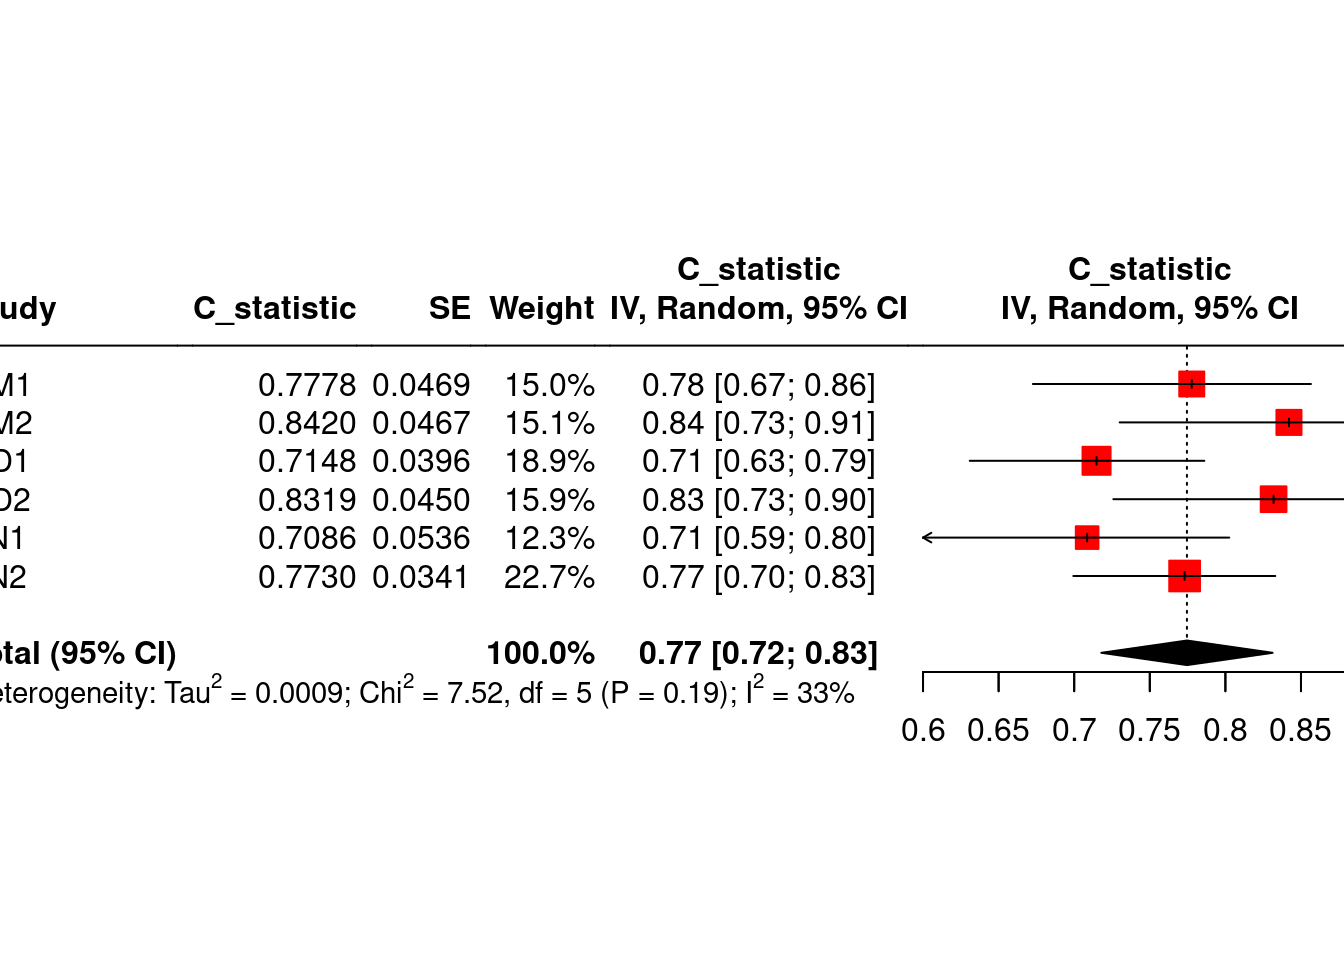

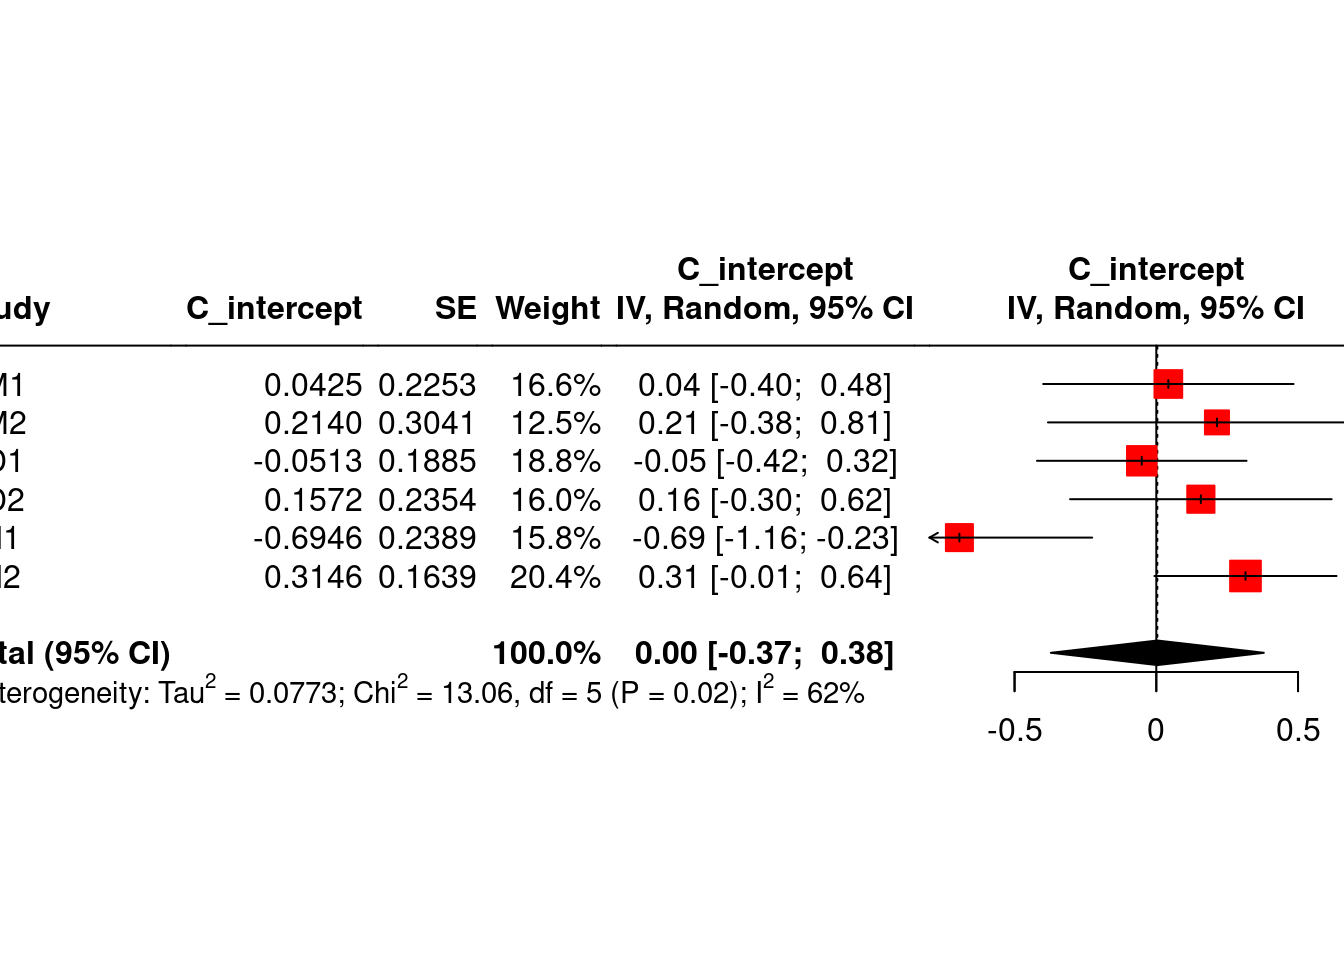

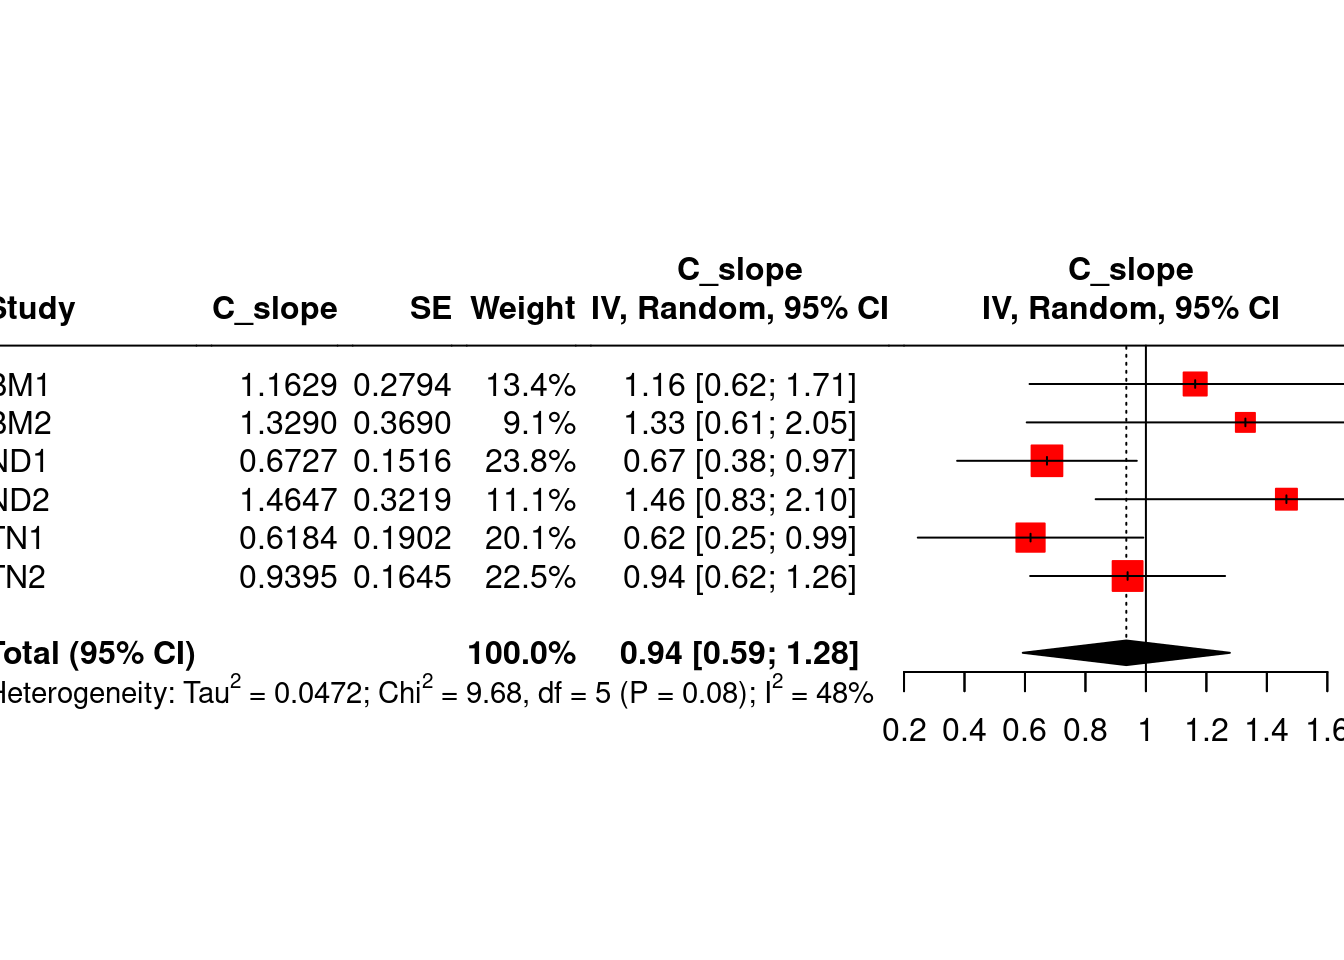

In [ ]:
library(meta)

cross_C_index_meta_BPM <- metagen(
  data = cross_estimates_BPM,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BPM <- forest(
  cross_C_index_meta_BPM,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  layout = "RevMan5"
)


In [ ]:
# save(cross_performance_metrics_HPM, file = "data/model-performance/cross-performance-metrics-HPM.rda")
save(cross_performance_metrics_BPM, file = "data/model-performance/cross-performance-metrics-BPM.rda")
